# Extend and Grading

In [1]:
%matplotlib inline
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules
%autoreload 2
# black formatter for jupyter notebooks
#%load_ext nb_black
# black formatter f|or jupyter lab
%load_ext lab_black

%run ../src/notebook_env.py


---------------------------------
Working on the host: Joachims-MacBook-Pro.local

---------------------------------
Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]

---------------------------------
Python interpreter: /opt/miniconda3/envs/idz-parostatus/bin/python

---------------------------------
Root (ROOT) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus
---------------------------------
data (DATA) directory is set to /Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/data
---------------------------------
Attaching the following source folders:
/Users/jokr/Documents/Projekte_Extern/IDZ/DMS-V-ParoStatus/src


**Import modules**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# from util import FdiNomenclaure, less_than_two_non_adjacent_teeth
# fdi = FdiNomenclaure()

## Load cohort dataset

In [4]:
fp = DATA.joinpath("processed")
fn = "dmsV_staged_periodontitis_cases.parquet"
file = fp.joinpath(fn)
assert file.exists()

data = pd.read_parquet(file)
data.shape

(927, 750)

## Disease  extent
Disease extent is described by the percentage of probed teeth presenting with the CAL condition of the identified stage, adding the number of teeth that are missing primarily due to periodontitis (if available). The number of missing teeth is determined for the same tooth positions, for which periodontal measurements were planned according to the probing protocol. For example, the maximum number of missing teeth is 28 for full-mouth periodontal recordings, 14 for half-mouth periodontal recordings, and 6 for Ramfjord teeth recordings. Wisdom teeth are excluded from calculations. Disease extent is categorized as `localized (<30%)` or `generalized (≥30%)`.

<img src=../_img/Extend.png>

### Missing values
Due to
* `No CAL measurement`
* `STAGE IV` assignment based on `< 10 teeth with occlusal surfaces`

In [5]:
data.affected_teeth.isnull().sum() / data.shape[0] * 100

19.41747572815534

### Assignment of `localized (<30%)` or `generalized (≥30%)`

Disease extent is described by the percentage of probed teeth presenting with the CAL condition of the identified stage, adding the number of teeth that are missing primarily due to periodontitis (if available). Disease extent is categorized as localized (<30%) or generalized (≥30%).

In [6]:
data["extend_in_percent"] = data["affected_teeth"] / data["zahnzahl"] * 100
data["extend"] = data["extend_in_percent"].apply(
    lambda x: np.nan
    if np.isnan(x)
    else "localized (<30%)"
    if x < 30
    else "generalized (≥30%)"
)

assert (
    data["extend"].isnull().sum() / data.shape[0] * 100
    == data.affected_teeth.isnull().sum() / data.shape[0] * 100
)

747


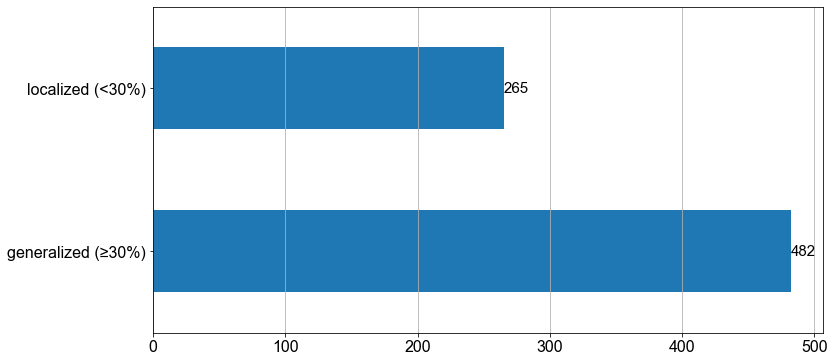

In [7]:
ax = data["extend"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
print(data["extend"].notnull().sum())

747


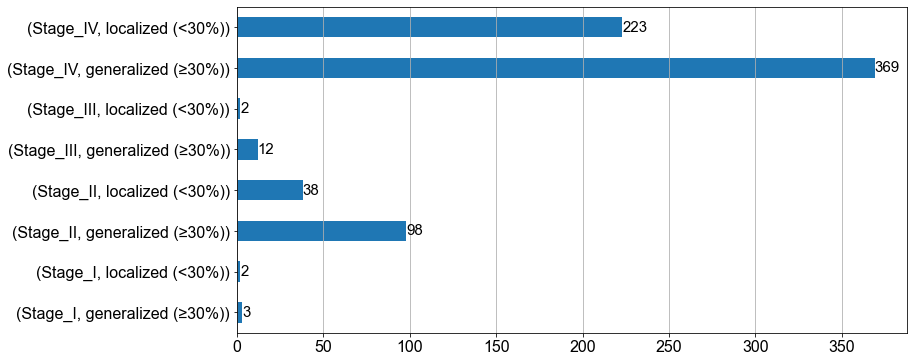

In [8]:
ax = data.groupby("classification")["extend"].value_counts().sort_index().plot.barh()
for container in ax.containers:
    ax.bar_label(container, size=15)
ax.grid(axis="x")
ax.set_ylabel("")
print(data["extend"].notnull().sum())

## Grading

Study participants can be graded if baseline data for bone loss (or follow-up data for bone loss or CAL), age, smoking status, the number of cigarettes per day, diabetes diagnosis, and HbA1c are non-missing. Periodontitis cases are first categorized as grade B (Tonetti et al., 2018). Participants with non-missing data for smoking status and the number of cigarettes per day, with no diagnosis of diabetes but missing HbA1c levels are graded as B (Figure 4). The periodontitis grade can then be modified by the smoking and the diabetes status. Non-smoking, normoglycemic periodontitis cases with no diagnosis of diabetes and % bone loss/age<0.25 are categorized as grade A. If periodontitis cases either have % bone loss/age>1.00 or are smokers with ≥10 cigarettes per day or are diabetes patients with an HbA1c ≥7.0%, they are categorized as grade C. Information on the case phenotype is usually not available in observational studies and is therefore not considered in the process of grading.

<img src=../_img/Grading.png>

## Save to disk

In [9]:
fn = "dmsV_staged_extend_periodontitis_cases.parquet"
fp = DATA.joinpath("processed", fn)
data.to_parquet(fp)
assert fp.exists(), fp